In [8]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torchvision.models.feature_extraction import create_feature_extractor,get_graph_node_names
import os 
import import_ipynb
from RetinaFPN import RetinaFPN as RetinaFPN

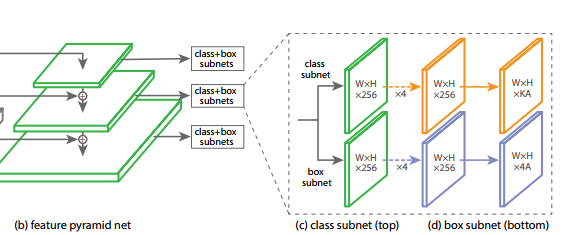
### Classification Subnet
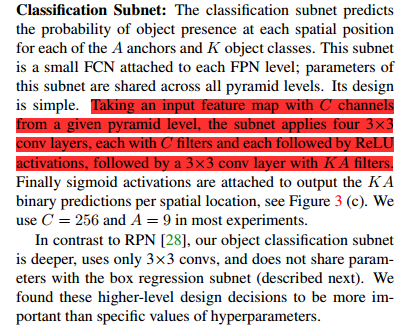

In [4]:
class Classification(nn.Module):
    def __init__(self, n_features_input, num_classes, num_anchors=9, feature_size=256):
        super(Classification, self).__init__()
        # C channels from given pyrmaid leve1 -> apply 4 3x3 conv layers each with C fiters -> ReLu -> 3x3 conv KA filter
        self.num_classes = num_classes
        self.num_anchors = num_anchors 

        self.conv1 = nn.Conv2d(n_features_input, feature_size, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        # K*A filters 
        self.final = nn.Conv2d(feature_size, num_classes*num_anchors, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.relu1(self.conv1(x))
        out = self.relu2(self.conv2(out))
        out = self.relu3(self.conv3(out))
        out = self.relu4(self.conv4(out))
        out=self.sigmoid(self.final(out))

        # dim(out) = batch_size * (num_classes*num_anchors) * W * H
        batch_size, channels, width, height = out.shape
        # permute the output to batch_size*width*height*(num_classes*num_anchors)
        out_perm = out.permute(0,2,3,1) # 

        # reshape the output to batch_size*width*height*num_anchors*num_classes
        out2 = out_perm.view(batch_size, width, height, self.num_anchors, self.num_classes)

        return out2.contiguous().view(x.shape[0], -1, self.num_classes)

In [9]:
net = RetinaFPN()
x = net(torch.randn(1,3,600,600))

In [15]:
print(x[0].shape)

torch.Size([1, 256, 73, 73])


In [30]:
class_net = Classification(256, 3)
xclass = class_net(x[0])

print(xclass.shape)
print(xclass[:,:,0])

torch.Size([1, 47961, 3])
tensor([[0.5029, 0.4972, 0.4995,  ..., 0.4968, 0.5019, 0.5012]],
       grad_fn=<SelectBackward0>)


In [31]:
print(73**2*9)

47961
